<a href="http://landlab.github.io"><img style="float: left" src="https://raw.githubusercontent.com/landlab/tutorials/master/landlab_header.png"></a>



# Introduction to the Landlab SpeciesEvolver component

<hr>
<small> For instructions on how to run an interactive Jupyter notebook, click here: <a href="https://github.com/landlab/tutorials/blob/master/README.md">https://github.com/landlab/tutorials/blob/master/README.md</a></small><br>
<small>For more Landlab tutorials, click here: <a href="https://github.com/landlab/landlab/wiki/Tutorials">https://github.com/landlab/landlab/wiki/Tutorials</a></small>
<hr>

In this tutorial we will build and run a model that exemplifies SpeciesEvolver functionality. You will have the opportunity to
* Populate a model grid with species. 
* View the SpeciesEvolver record that stores model variables over time.
* See how species are assigned identifiers.
* Plot some model output.

## Example model: climate change impacts on species distribution and evolution

### Premise

The elevational distribution of ecosystems is largely controlled by air temperature. Ecosystems zonate by elevation largely because temperature decreases with altitude. Longterm temperature change drives elevational redistribution of ecosystems.

### Approach

We model the macroevolutionary processes of species in response to temperature change. For simplicity, species distribution is set only by temperature. Temperature is set by elevation using a lapse rate, the decrease of temperature with elevation. Also for simplicity, topography does not change during the duration of the model.

The model progresses in terms of time steps with an unprescribed duration.

We will use `ZoneSpecies`. This species type is distributed with SpeciesEvolver and relies on `Zone` objects to evaluate evolutionary processes. The macroevolutionary processes built into ZoneSpecies are
* dispersal: geographic range expansion
* speciation: lineage splitting
* extinction: lineage termination

Species geographic range in this model are set to a temperature range, meaning the extent of zones is within this temperature range and all species exist only in this temperature range. 

### Summary

In this model, we

* Set surface air temperture across a model grid. Temperature will be a function of elevation.
* Populate species onto the grid. These species exist within a fixed temperature interval.
* Simulate a time step where surface temperature has changed and species respond to this change.

### Import modules

The zones of ZoneSpecies are managed by a `ZoneController`, so we must import this class along with the SpeciesEvolver component and the other modules used in this notebook.

In [1]:
from landlab.components import SpeciesEvolver
from landlab.components.species_evolution import ZoneController
from landlab.io import read_esri_ascii
from landlab.plot import imshow_grid
import matplotlib.pyplot as plt
import numpy as np

### Prepare the grid

In this tutorial, the topography of the model grid is loaded from a file. The topography was previously developed using a model built with Landlab. An initial surface was uplifted, stream erosion was conducted using the FastscapeEroder component, and hillslope diffusion was conducted using the LinearDiffuser component. The model was run until topography reached steady state.

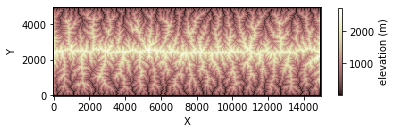

In [2]:
# Create a model grid and set a topographic elevation field.
(mg, z) = read_esri_ascii('model_grid_steady_state_elevation.txt')
mg.at_node['topographic__elevation'] = z

# Set the top and bottom grid boundaries to open.
mg.set_closed_boundaries_at_grid_edges(right_is_closed=True,
                                       top_is_closed=False,
                                       left_is_closed=True,
                                       bottom_is_closed=False)

# Plot the elevation field.
imshow_grid(mg, 'topographic__elevation', colorbar_label='elevation (m)', shrink=0.4)

### Create a grid field of air temperature at the land surface

We set a surface air temperature at base level (upper and lower boundaries). We use a lapse rate to create a synthetic surface air temperature field at all nodes of the grid. The lapse rate, *L* is modeled as the decrease of temperature, *T* with increasing elevation, *z* as

\begin{align*}
L = -\frac{\delta t}{\delta z}
\end{align*}

We use a lapse rate of -6&deg;C / km.

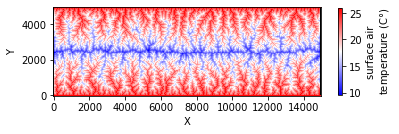

In [3]:
# Set a rate of temperature decrease per meter of elevation increase.
lapse_rate = -0.006

# Create a surface temperature field.
temperature_at_base_level = 26
T = lapse_rate * z + temperature_at_base_level
mg.add_field('node', 'land_surface_air__temperature', T)

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

### Create a zone function

Zones are portions of a model grid. A `ZoneSpecies` object exists within a zone or multiple zones. `Zone` objects are explained in more detail later in this tutorial.

The general workflow we will conduct is

* Define a function that demarcates the combined extent of all zones. 
* Populate each distinct zone with a species.

The zone function acts to return a numpy array where `True` values indicate where zones should be created. Each distinct zone is created where `True` nodes are spatially continuous.

The zone function has two requirements:
1. It must return a numpy array with the length of the grid's `number_of_nodes`.
2. The first parameter must be named `grid`. It is the same Landlab grid supplied to SpeciesEvolver. Additional parameters are allowed.

Here, we define a zone function that indicates zones should be created where the air temperature is between 15&deg;C and 25&deg;C, inclusive.

In [4]:
def zone_func(grid):
    """Get a mask of the total zone extent."""
    T = grid.at_node['land_surface_air__temperature']
    T_max = 25
    T_min = 15
    zone_extent_mask = np.all([T >= T_min, T <= T_max], 0)
    return zone_extent_mask

`True` values are shaded white in the plot below

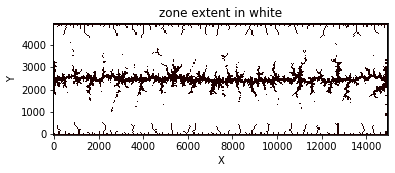

In [5]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False, plot_name='zone extent in white')

### Initialize SpeciesEvolver

This component requires only one parameter, a model grid, for the default functionality.

In [6]:
se = SpeciesEvolver(mg)

View the `record` of our SpeciesEvolver instance. Time and other model variables are stored in the record. The first and second columns are the row number and model time, respectively. We also see that 0 species exist. We have yet to introduce species.

In [7]:
se.record

,time,species_count
0,0,0


### Instantiate a SpeciesController

Next, we instantiate a ZoneController that will handle the zones.

In [8]:
sc = ZoneController(mg, zone_func, minimum_area=50000)

Two distinct areas of the mask are now seperated by the higher elevations in the center of the grid.

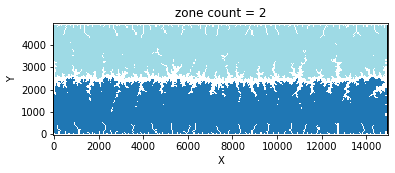

In [9]:
# Plot zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(sc.zones):
    zone_map[zone.mask] = i + 1
    
cmap = plt.cm.tab20
cmap.set_under('w')
title = 'zone count = {}'.format(len(sc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=1)

### Seed zones with species

One species is populated to each of the two initial zones using the ZoneController method, `populate_zones_uniformly`. This method creates the species for each of the two zones. All species must be introduced using the SpeciesEvolver method, `introduce_species` in order for the species to be tracked by SpeciesEvolver.

The SpeciesEvolver attribute, `species` provides data about all of the introduced species. The data is presented in a Pandas DataFrame. The `clade` and `species_number` identifier elements will be explained later in the tutorial.

In [10]:
species = sc.populate_zones_uniformly(1)

se.introduce_species(species)

# Display the species data frame.
se.species

,clade,number,time_appeared,latest_time
0,A,0,0,0
1,B,0,0,0


Two species now exist in the initial time.

In [11]:
se.record

,time,species_count
0,0,2


### Simulate a temperature increase and its impact on species distribution

The temperature at base level is increased by 6&deg;C.

< FIX COLOR MAP >

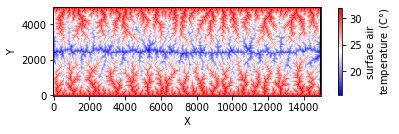

In [12]:
# Update the surface temperature field.
temperature_at_base_level = 32
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

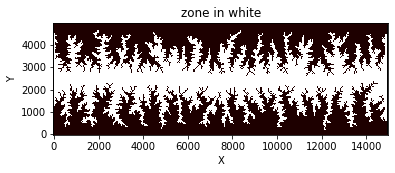

In [13]:
# Advance SpeciesEvolver by a time step. The duration of a time step is not prescribed in this tutorial.
dt = 1
sc.run_one_step(dt)
se.run_one_step(dt)

# Plot zones.
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

### Simulate a second temperature increase

The temperature at base level is increased again by 6&deg;C.

21.5959030999 37.9999927129


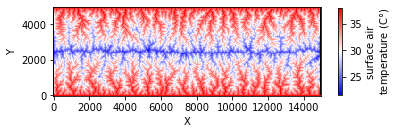

In [14]:
# Update the surface temperature field.
temperature_at_base_level = 38
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())

# Plot temperature field.
imshow_grid(mg, 'land_surface_air__temperature',
            colorbar_label='surface air\ntemperature (C$\degree$)',
            shrink=0.4, cmap='bwr')

n_zones 1


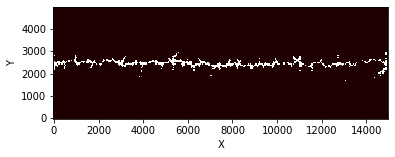

In [15]:
imshow_grid(mg, zone_func(mg), allow_colorbar=False)
print('n_zones', len(sc.zones))

In [16]:
se.record

,time,species_count,speciation_count,extinction_count,pseudoextinction_count
0,0,2,NaN,NaN,NaN
1,1,2,0.0,0.0,0.0


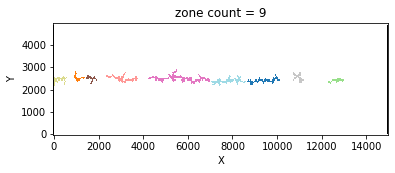

In [17]:
# Advance SpeciesEvolver by one unit of time. Time is dimensionless in this tutorial.
dt = 1
sc.run_one_step(dt)
se.run_one_step(dt)

# Plot zones.
zone_map = np.zeros(mg.number_of_nodes)
for i, zone in enumerate(sc.zones):
    zone_map[zone.mask] = i + 1
    
cmap = plt.cm.tab20
cmap.set_under('w')
title = 'zone count = {}'.format(len(sc.zones))
imshow_grid(mg, zone_map, cmap=cmap, allow_colorbar=False, plot_name=title, vmin=1)

In [18]:
se.species

,clade,number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,2
2,A,2,2,2
3,A,3,2,2
4,A,4,2,2
5,A,5,2,2
6,A,6,2,2
7,A,7,2,2
8,A,8,2,2
9,A,9,2,2


Three species have existed in this model:

- A.0: The initial species we introduced.
- A.1 and A.2: The child species of A.0. These species were created when the zone of the first time step split into two in the second time step.

All species belong to clade 'A' because the child species (A.1 and A.2) were spawned from the same parent species (A.0).


**Profile map**
```
              N
     ___________________
    │    P1             │
    │     │             │
 W  │ P2──┼───────      │  E
    │     │             │
    │                   │
     ‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾‾
              S


```
**T0**: Profile 1
```
            ╱╲
           ╱  ╲
   N     a╱    ╲*     S     ─┐
        a╱      ╲*           │ Species temperature range
   aaaaa╱        ╲*****      │
   ‾‾‾‾‾          ‾‾‾‾‾     ─┘ 
                             

```
**T1**: Profile 1
```    
            *a
          *a╱╲*a            ─┐
         *a╱  ╲*a            │ Species temperature range
   N    *a╱    ╲*a    S      │
       *a╱      ╲*a         ─┘
        ╱        ╲
   ‾‾‾‾‾          ‾‾‾‾‾


```
**T3**: Profile 1 (left) and 2 (right)
```                  
                                                             ─┐
                                                              │ Species temperature range
            b+                     +b                c@       │ 
          b+╱╲b+                 +b╱╲+b            c@╱╲c@    ─┘
           ╱  ╲                   ╱  ╲      ╱╲      ╱  ╲
   N      ╱    ╲      S      W   ╱    ╲    ╱  ╲    ╱    ╲   E
         ╱      ╲               ╱      ╲  ╱    ╲  ╱      ╲
        ╱        ╲             ╱        ╲╱      ╲╱        ╲
   ‾‾‾‾‾          ‾‾‾‾‾    


```
**Phylogeny**
```

         ┌─ b
a ───────┤
         └─ c
         ┌─ +
* ───────┤
         └─ @
 __________
T0   T1   T2

```


In [19]:
se.record

,time,species_count,speciation_count,extinction_count,pseudoextinction_count
0,0,2,NaN,NaN,NaN
1,1,2,0.0,0.0,0.0
2,2,18,18.0,0.0,2.0


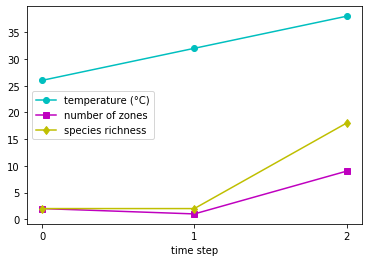

In [20]:
time = [0, 1, 2]
temperature = [26, 32, 38]
n_zones = [2, 1, 9]
species_richness = se.record.species_count

plt.plot(time, temperature, 'o-c', label='temperature (\N{DEGREE SIGN}C)')
plt.plot(time, n_zones, 's-m', label='number of zones')
plt.plot(time, se.record.species_count, 'd-y', label='species richness')
plt.xlabel('time step')
plt.xticks(time)
_ = plt.legend()

## Species identifiers

Species identifiers are automatically generated. They are stored as tuples in species objects. The first element of the identifier tuple is the clade name, and the second element is the species number. For example, the first species of clade A is 0, so the identifier is (A, 0) and the tenth species of this clade is (A, 9).

### Clade name

A clade is a group of species that share a common ancestor. Species may share multiple common ancestors, so clades can be defined differently in the same tree. The clade(s) of this example tree can be defined in multiple ways:

<img src="images/clade_definitions.png" style="width: 400px;"/>

In SpeciesEvolver, clades are defined by the root node for the purpose of assigning species identifiers. The species at the root node is:
* the least recent common ancestor of all species in the tree, and
* typically introduced to a SpeciesEvolver model using the ```introduce_species``` function.

The clades of the first 26 species are named alphabetically from A to Z. The alphabet is repeated for subsequent species following this schema:

<center>clade sequence</center> | <center>clade name</center>
--- | ---
1–26 | A–Z
27–52 | AA–AZ
53–78 | BA–BZ
... | ...
703–728 | AAA–AAZ
729–754 | ABA–ABZ
... | ...

### Species number

The species of a clade are numbered sequently beginning with 0.

In the example tree below, species A.0 produced 4 child species. Only one species, B.0 exists in clade B because child species were not produced by B.0.

<img src="images/species_identifier.png" style="width: 250px;"/>

In [21]:
# Update the surface temperature field.
temperature_at_base_level = 20
mg.at_node['land_surface_air__temperature'] = lapse_rate * z + temperature_at_base_level

print(mg.at_node['land_surface_air__temperature'].min(), mg.at_node['land_surface_air__temperature'].max())

sc.run_one_step(dt)
se.run_one_step(dt)

3.59590309985 19.9999927129


In [22]:
for zone in sc.zones:
    plt.figure()
    imshow_grid(mg, zone.mask, allow_colorbar=False, plot_name='zone in white')

### About Zones

Zones are portions of a model grid. A Species object exists throughout a zone.

At each timestep, the spatial intersection of the zones at the prior time and current time are identified and typed. For example, a zone in the prior time intersects two zones in the current time. This zone path is typed one-to-many.

Macroevolutionary processes are carried out by the intersection of zones over time. The connectivity of zones in SpeciesEvolver are called 'paths', and the relationship of zones is described by the path type. Not all combinations of none, one, and many are considered at the time of this tutorial. All none-to-n and some many-to-n are not considered. 

<img style="float: left;" src="images/zone__one_to_none.png"> &nbsp; zone<sub>*t*</sub>: a zone in time, *t*.<br>

<img style="float: left;" src="images/zone__later_time.png"> &nbsp; zone<sub>*t*+1</sub>: a zone in the time following *t*.

<center>path type</center> | <center>graphical<br>represention</center> | <center>zone temporal connectivity</center> | <center>macroevolution implications</center>
--- | --- | --- | ---
one-to-none | ![](images/zone__one_to_none.png) | zone<sub>*t*</sub> does not intersect a zone in *t*+1. | The species in the zone of the earlier time will go extinct. 
one-to-one | ![](images/zone__one_to_one.png) | zone<sub>*t*</sub> intersects zone<sub>*t*+1</sub>. | The species in the zone of the earlier time will relocate to the zone of the later time.
one-to-many | ![](images/zone__one_to_many.png) | zone<sub>*t*</sub> intersects multiple zones in *t*+1. | The species in the zone of the earlier time disperses across the multiple zones in the later time. The species in the zones of the later time are geographical disconnected, thus speciation occurs.
many-to-one | ![](images/zone__many_to_one.png) | Multiple zones in *t* intersect zone<sub>*t*+1</sub>. | Species density increases locally.
many-to-many | ![](images/zone__many_to_many.png) | Multiple zones in *t* intersect multiple zones in *t*+1. | Species distribution shifts. Speciation occurs where the zone of a species at *t* intersects more than one zone at *t*+1.

The rules of macroevolution are programmed into species. Behind the scenes, zone paths are the conditions evaluated by the macroevolution rules. The outcome of the rules given the zone paths are described in the zone table above. For example, a one-to-many path:

![](images/zone_path__one_to_many.png)

The base species class 

Users may develop species with different behaviors and macroevolution rules.





Populate SpeciesEvolver zones with species.



In [23]:
se.species

,clade,number,time_appeared,latest_time
0,A,0,0,1
1,A,1,2,2
2,A,2,2,2
3,A,3,2,2
4,A,4,2,2
5,A,5,2,2
6,A,6,2,2
7,A,7,2,2
8,A,8,2,2
9,A,9,2,2


In [24]:
se.record

,time,species_count,speciation_count,extinction_count,pseudoextinction_count
0,0,2,NaN,NaN,NaN
1,1,2,0.0,0.0,0.0
2,2,18,18.0,0.0,2.0
3,3,0,0.0,18.0,0.0


In [25]:
sc.record

,time,zone_count,capture_count,area_captured_sum,fragmentation_count,area_captured_max
0,0,2,NaN,NaN,NaN,NaN
1,1,1,1.0,32542500.0,0.0,32542500.0
2,2,9,0.0,0.0,1.0,0.0
3,3,0,0.0,0.0,0.0,0.0


DataFrame methods can be used on `record`. For example, here we get the maximum capture count.

In [26]:
sc.record.capture_count.max()

1.0

## Query species

SpeciesEvolver provides methods that return species objects in the event you need to work with specific instances of species.

The method, `species_at_time` returns species that were extant at the inputted time.

In [27]:
se.species_at_time(1)

The method, `species_with_identifier` takes various combinations of species identifiers. See the documentation of this method for details. Here we get all the species of clade A.

In [28]:
se.species_with_identifier('A')

### Click here for more <a href="https://github.com/landlab/landlab/wiki/Tutorials">Landlab tutorials</a>